In [13]:
from pymongo import MongoClient
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score , train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pymongo import MongoClient
import json

In [14]:

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Doodle_Classifier"]
collection = db["Extracted_Features"]

# Fetch data into a DataFrame
data = pd.DataFrame(list(collection.find()))
data.drop(columns=["_id", "id"], inplace=True)  

In [15]:

X = data.drop(columns=["label"])
y = data["label"]

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df['label'] = y.values
X_scaled_df['original_index'] = X_scaled_df.index

# Store filtered indices
kept_indices = []

print("Removing outliers using clustering per class...\n")

for label in X_scaled_df['label'].unique():
    class_data = X_scaled_df[X_scaled_df['label'] == label].drop(columns=['label', 'original_index'])
    original_indices = X_scaled_df[X_scaled_df['label'] == label]['original_index'].values

    # Cluster to find center
    kmeans = KMeans(n_clusters=1, random_state=42).fit(class_data)
    center = kmeans.cluster_centers_[0]

    # Compute distances to center
    distances = np.linalg.norm(class_data - center, axis=1)

    # Define outlier threshold (mean + 1/2 * std)
    threshold = distances.mean() + 0.5 * distances.std()

    # Keep only inliers
    inlier_mask = distances <= threshold
    inlier_indices = original_indices[inlier_mask]
    kept_indices.extend(inlier_indices)

    print(f"Class: {label}")
    print(f"  Total: {len(class_data)}")
    print(f"  Removed: {len(class_data) - len(inlier_indices)}")
    print(f"  Remaining: {len(inlier_indices)}\n")

# Filter the dataset to only keep inliers
filtered_data = data.iloc[kept_indices].reset_index(drop=True)

X_scaled = filtered_data.drop(columns=["label"])
y = filtered_data["label"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)


print("✅ Final Dataset:")
print(f"  Total samples before: {len(data)}")
print(f"  Total samples after:  {len(filtered_data)}")
print(f"  Total removed:        {len(data) - len(filtered_data)}")

Removing outliers using clustering per class...

Class: car
  Total: 716
  Removed: 101
  Remaining: 615

Class: fish
  Total: 716
  Removed: 122
  Remaining: 594

Class: house
  Total: 716
  Removed: 116
  Remaining: 600

Class: tree
  Total: 716
  Removed: 107
  Remaining: 609

Class: bicycle
  Total: 716
  Removed: 78
  Remaining: 638

Class: guitar
  Total: 716
  Removed: 159
  Remaining: 557

Class: pencil
  Total: 716
  Removed: 146
  Remaining: 570

Class: clock
  Total: 716
  Removed: 115
  Remaining: 601

✅ Final Dataset:
  Total samples before: 5728
  Total samples after:  4784
  Total removed:        944


In [ ]:
# mongo_docs = []
# add_collection = db["Filtered_Features"]

# for idx, row in filtered_data.iterrows():
#     doc = {
#         "label": row["label"],
#         "features": {}
#     }
#     for col in filtered_data.columns:
#         if col != "label":
#             doc["features"][col] = row[col]
#     mongo_docs.append(doc)

# add_collection.insert_many(mongo_docs)

InsertManyResult([ObjectId('689425366587fab5d75bf98e'), ObjectId('689425366587fab5d75bf98f'), ObjectId('689425366587fab5d75bf990'), ObjectId('689425366587fab5d75bf991'), ObjectId('689425366587fab5d75bf992'), ObjectId('689425366587fab5d75bf993'), ObjectId('689425366587fab5d75bf994'), ObjectId('689425366587fab5d75bf995'), ObjectId('689425366587fab5d75bf996'), ObjectId('689425366587fab5d75bf997'), ObjectId('689425366587fab5d75bf998'), ObjectId('689425366587fab5d75bf999'), ObjectId('689425366587fab5d75bf99a'), ObjectId('689425366587fab5d75bf99b'), ObjectId('689425366587fab5d75bf99c'), ObjectId('689425366587fab5d75bf99d'), ObjectId('689425366587fab5d75bf99e'), ObjectId('689425366587fab5d75bf99f'), ObjectId('689425366587fab5d75bf9a0'), ObjectId('689425366587fab5d75bf9a1'), ObjectId('689425366587fab5d75bf9a2'), ObjectId('689425366587fab5d75bf9a3'), ObjectId('689425366587fab5d75bf9a4'), ObjectId('689425366587fab5d75bf9a5'), ObjectId('689425366587fab5d75bf9a6'), ObjectId('689425366587fab5d75bf9

In [18]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [19]:
X.columns

Index(['no_strokes', 'no_points', 'avg_stroke_length', 'bbox_width',
       'bbox_height', 'aspect_ratio', 'centroid_x', 'centroid_y',
       'compactness', 'convex_hull_area', 'horizontal_symmetry',
       'vertical_symmetry', 'straightness', 'start_x', 'start_y', 'end_x',
       'end_y', 'area', 'perimeter'],
      dtype='object')

In [20]:
X_scaled[1]

array([-3.19205879e-01, -3.99092819e-01, -4.30283447e-01,  8.17763730e-01,
       -5.11781938e-01, -5.85022443e-01,  8.74231528e-01, -3.33621475e-01,
       -7.34077047e-01,  2.85041080e-02, -4.96616746e-01,  1.17895445e+00,
       -1.19184171e+00, -6.51091053e-01, -6.84408347e-02, -1.71850929e+00,
       -2.02210290e-01, -7.19679008e-04, -6.23076762e-01])

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

mlp = MLPClassifier(max_iter=1000, early_stopping=True, random_state=42)

grid = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_scaled, y_encoded)

print("Best MLP Parameters:", grid.best_params_)
print("Best Cross-Validated Accuracy:", grid.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best MLP Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'constant', 'solver': 'adam'}
Best Cross-Validated Accuracy: 0.7134201007172928


In [ ]:
models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "MLP": MLPClassifier(max_iter=1000)
}


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if name == "MLP":
        mlp = model
        plt.plot(mlp.loss_curve_)
        plt.title("MLP Training Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
    
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


NameError: name 'models' is not defined

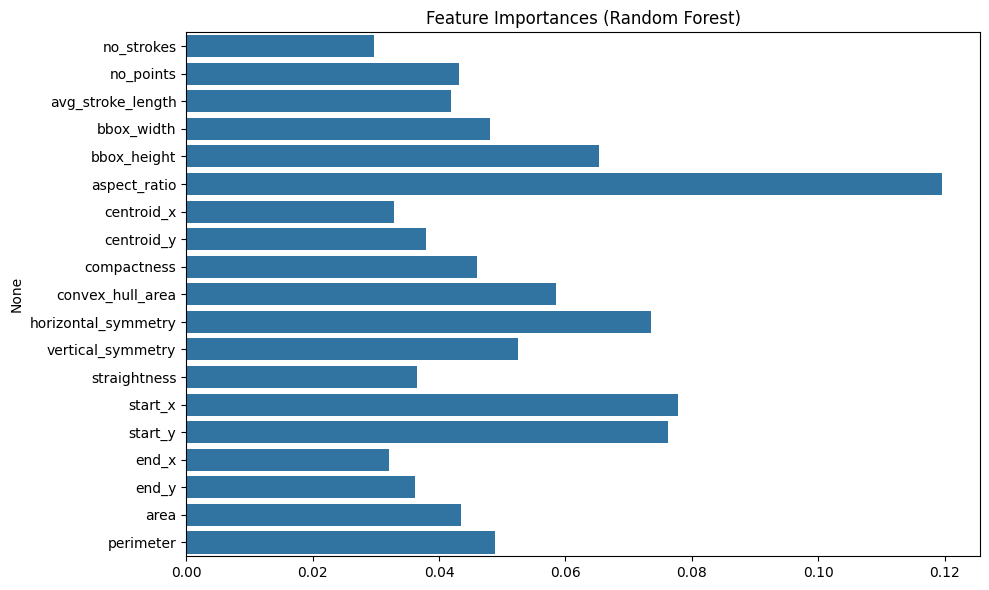

In [ ]:

rf = RandomForestClassifier()
rf.fit(X_scaled, y_encoded)

importances = rf.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()



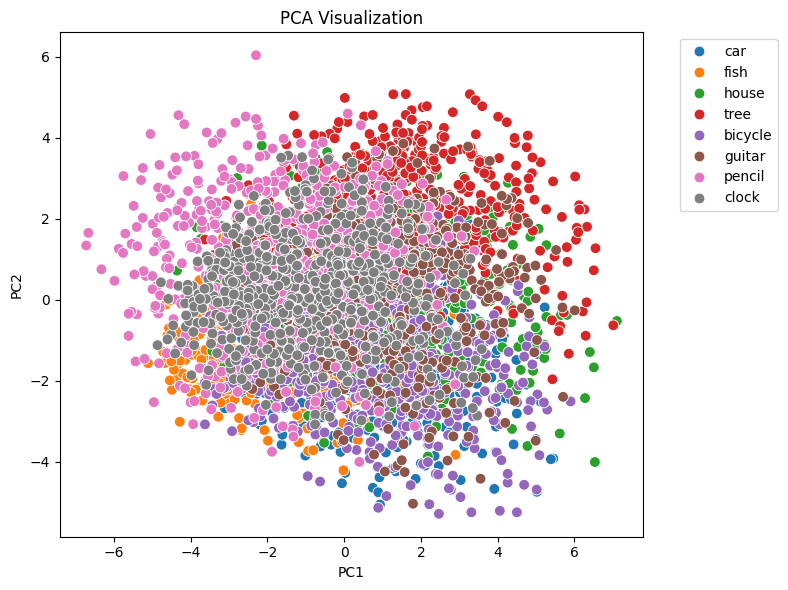

In [ ]:

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE 
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X_scaled)


# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=label_encoder.inverse_transform(y_encoded), palette="tab10", s=60)
plt.title("PCA Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


KMeans Silhouette Score: 0.11017680487673606
DBSCAN Silhouette Score: -0.19621467193277342


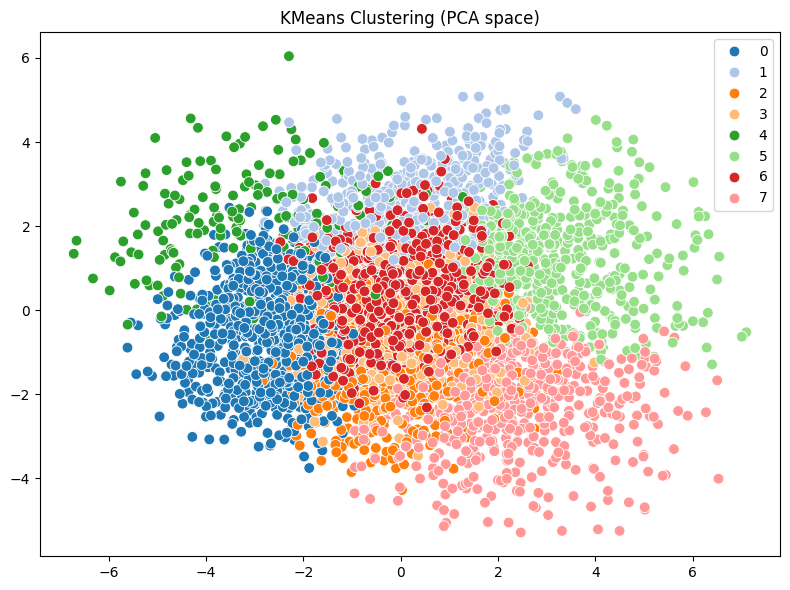

In [ ]:

# KMeans
kmeans = KMeans(n_clusters=len(label_encoder.classes_), random_state=42)
k_labels = kmeans.fit_predict(X_scaled)
print("KMeans Silhouette Score:", silhouette_score(X_scaled, k_labels))

# DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)
print("DBSCAN Silhouette Score:", silhouette_score(X_scaled, db_labels))

# Visualize Clusters using PCA
# show the corresponding label of the colors 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=k_labels, palette="tab20", s=60)
plt.title("KMeans Clustering (PCA space)")
plt.tight_layout()
plt.show()

DBSCAN Silhouette Score: -0.19621467193277342
Sampling up to 100 points per class...
bicycle: 100 points (from 638)
car: 100 points (from 615)
clock: 100 points (from 601)
fish: 100 points (from 594)
guitar: 100 points (from 557)
house: 100 points (from 600)
pencil: 100 points (from 570)
tree: 100 points (from 609)


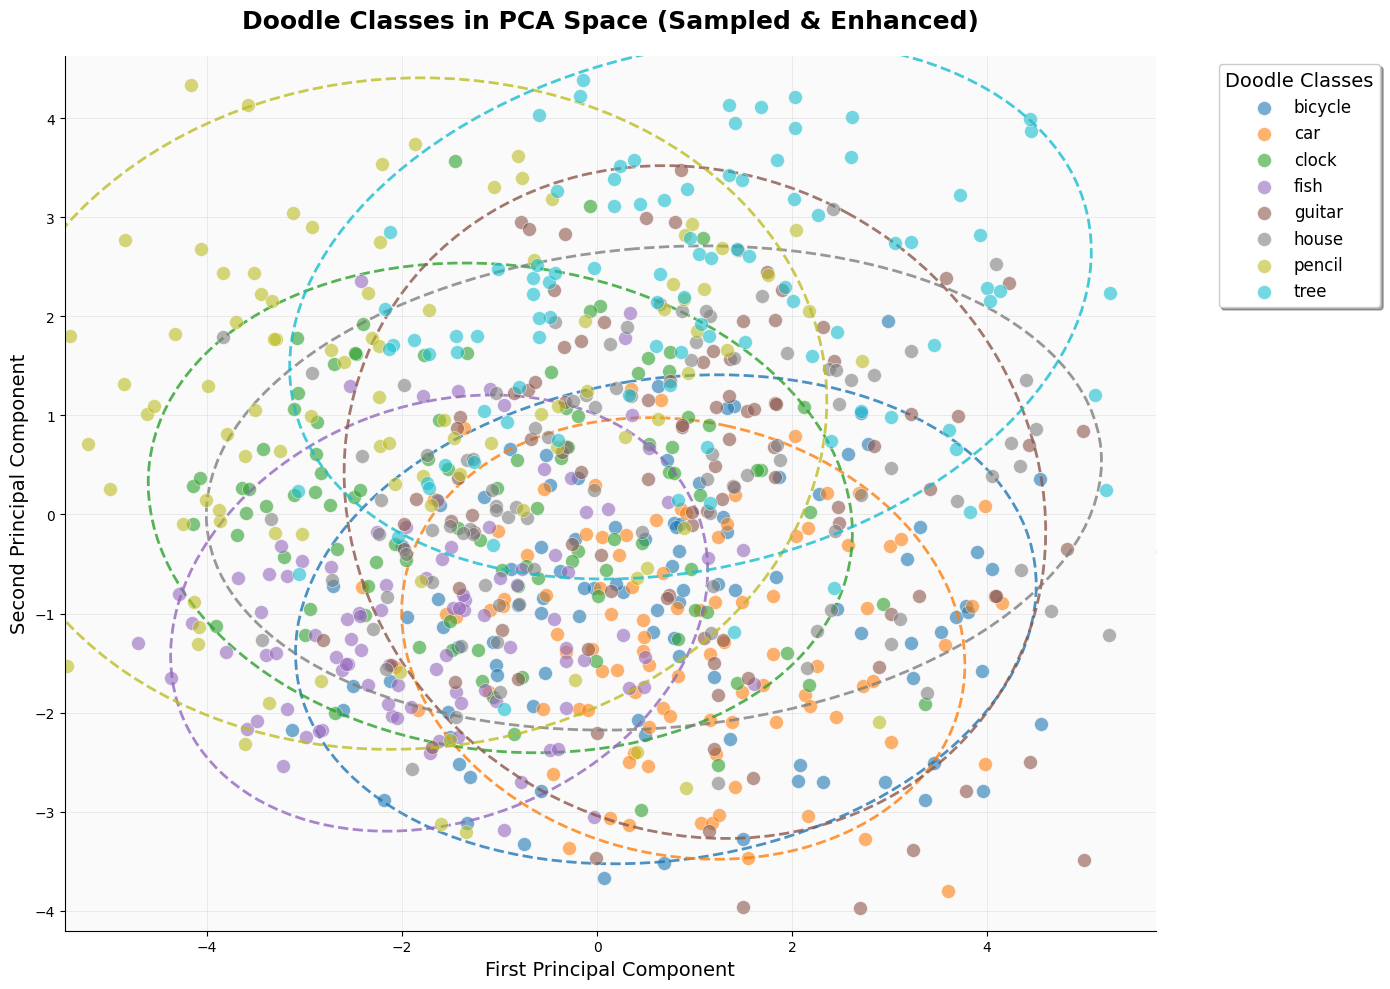


Visualization Summary:
Total original points: 4784
Total sampled points: 800
Classes visualized: 8
Dashed ellipses show ~95% confidence regions for each class


In [ ]:
# Plotting the actual labels in PCA space with cleaner visualization
from matplotlib.patches import Ellipse
from sklearn.covariance import EmpiricalCovariance

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get actual labels (not cluster predictions)
actual_labels = label_encoder.inverse_transform(y_encoded)

# DBSCAN for comparison (keeping the silhouette score)
dbscan = DBSCAN(eps=2, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)
print("DBSCAN Silhouette Score:", silhouette_score(X_scaled, db_labels))

# Sample fewer points per class for cleaner visualization
max_samples_per_class = 100  # Adjust this number as needed
sampled_indices = []

print(f"Sampling up to {max_samples_per_class} points per class...")
for class_name in np.unique(actual_labels):
    class_indices = np.where(actual_labels == class_name)[0]
    if len(class_indices) > max_samples_per_class:
        # Randomly sample points from this class
        sampled_class_indices = np.random.choice(class_indices, max_samples_per_class, replace=False)
    else:
        sampled_class_indices = class_indices
    sampled_indices.extend(sampled_class_indices)
    print(f"{class_name}: {len(sampled_class_indices)} points (from {len(class_indices)})")

# Apply sampling
X_pca_sampled = X_pca[sampled_indices]
actual_labels_sampled = actual_labels[sampled_indices]

# Create the plot with enhanced visualization
plt.figure(figsize=(14, 10))

# Define colors for consistency
colors = plt.cm.tab10(np.linspace(0, 1, len(np.unique(actual_labels_sampled))))
class_to_color = dict(zip(np.unique(actual_labels_sampled), colors))

# Plot points with larger size and some transparency
for i, class_name in enumerate(np.unique(actual_labels_sampled)):
    class_mask = actual_labels_sampled == class_name
    class_points = X_pca_sampled[class_mask]
    
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[class_to_color[class_name]], 
               s=100, alpha=0.6, 
               label=class_name, 
               edgecolors='white', linewidth=0.5)
    
    # Add confidence ellipse around each class
    if len(class_points) > 2:  # Need at least 3 points for ellipse
        try:
            # Calculate mean and covariance
            mean = np.mean(class_points, axis=0)
            cov = np.cov(class_points.T)
            
            # Create ellipse (2 standard deviations = ~95% confidence)
            eigenvals, eigenvecs = np.linalg.eigh(cov)
            order = eigenvals.argsort()[::-1]
            eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
            
            # Calculate ellipse parameters
            angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))
            width, height = 2 * 2 * np.sqrt(eigenvals)  # 2 std deviations
            
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                            facecolor='none', edgecolor=class_to_color[class_name], 
                            linewidth=2, linestyle='--', alpha=0.8)
            plt.gca().add_patch(ellipse)
            
        except:
            # Skip ellipse if calculation fails
            pass

# Enhanced styling
plt.title("Doodle Classes in PCA Space (Sampled & Enhanced)", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("First Principal Component", fontsize=14)
plt.ylabel("Second Principal Component", fontsize=14)

# Position legend outside the plot area with better formatting
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
          title='Doodle Classes', title_fontsize=14, fontsize=12,
          frameon=True, fancybox=True, shadow=True)

# Add zoom by setting axis limits to focus on the main data cluster
x_min, x_max = np.percentile(X_pca_sampled[:,0], [2, 98])
y_min, y_max = np.percentile(X_pca_sampled[:,1], [2, 98])

x_padding = (x_max - x_min) * 0.15
y_padding = (y_max - y_min) * 0.15

plt.xlim(x_min - x_padding, x_max + x_padding)
plt.ylim(y_min - y_padding, y_max + y_padding)

# Enhanced grid
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Add some styling to the plot
plt.gca().set_facecolor('#fafafa')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print sampling summary
print(f"\nVisualization Summary:")
print(f"Total original points: {len(X_pca)}")
print(f"Total sampled points: {len(X_pca_sampled)}")
print(f"Classes visualized: {len(np.unique(actual_labels_sampled))}")
print(f"Dashed ellipses show ~95% confidence regions for each class")